En este análisis, trabajaré con una base de datos de la Liga MX, que abarca los resultados de partidos disputados entre 2016 y 2023. El objetivo es aplicar regresión logística para predecir si un partido tendrá un ganador o terminará en empate, utilizando variables como los goles anotados, la localía y otros factores relevantes.


La base de datos contiene diversas variables relacionadas con los encuentros, incluyendo información sobre los equipos, el arbitraje, los goles y otros aspectos relevantes. A continuación, se describen las variables incluidas en el análisis:



*   id: Número de identificación del partido.
*   referee: Nombre del árbitro.
*   referee: Nombre del árbitro.
*   timezone: Zona horaria en la que se disputó el partido.
*   date: Fecha del encuentro.
*   venue_id: Identificación del estadio.
*   venue_name: Nombre del estadio.
*   venue_city: Ciudad donde se ubica el estadio.
*   season: Temporada en la que se jugó el partido.
*   round: Jornada del torneo en la que se disputó el encuentro.
*   home_team: Equipo que juega como local.
*   away_team: Equipo que juega como visitante.
*   away_win: Equipo ganador del partido.
*   home_goals: Cantidad de goles anotados por el equipo local.
*   away_goals: Cantidad de goles anotados por el equipo visitante.
*   home_goals_half_time: Goles del equipo local al medio tiempo.
*   away_goals_half_time: Goles del equipo visitante al medio tiempo.
*   home_goals_fulltime: Goles del equipo local al final del tiempo reglamentario.
*   away_goals_fulltime: Goles del equipo visitante al final del tiempo reglamentario.
*   home_goals_extra_time: Goles del equipo local en tiempo extra.
*   away_goals_extra_time: Goles del equipo visitante en tiempo extra.
*   home_goals_penalty: Goles del equipo local en tanda de penales.
*   away_goals_penalty: Goles del equipo visitante en tanda de penales.
*   has_winner: que es la variable binarizada que tiene 1 si el equipo gana y 0 si el equipo pierde o empata





La base de datos utilizada en este estudio fue obtenida de Kaggle en el siguiente enlace:

LigaMX. (2024, 25 de junio). Kaggle. https://www.kaggle.com/datasets/gerardojaimeescareo/ligamx-matches-2016-2022

In [72]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Se cargan los datos
df = pd.read_csv("LigaMx2016-2023.csv")

# Se eliminan columnas que no aportan al modelo
columnas_a_eliminar = ["id", "referee", "timezone", "date", "venue_id", "venue_name", "venue_city", "season", "round"]
df = df.drop(columns=columnas_a_eliminar, errors='ignore')

# Se eliminan filas con valores NaN
df = df.dropna()

# Se eliminan columnas categóricas irrelevantes
df = df.drop(columns=["home_team", "away_team"], errors='ignore')

# Se convierten columnas booleanas a enteros
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# Calcular la matriz de correlación antes de eliminar 'has_winner'
cor_matrix = df.corr().abs()
upper_triangle = np.triu(np.ones(cor_matrix.shape), k=1)
high_corr_pairs = np.where(cor_matrix > 0.85)
variables_to_drop = set()

# Excluir 'has_winner' de la lista de variables a eliminar
for i, j in zip(*high_corr_pairs):
    if i != j and cor_matrix.columns[j] != 'has_winner':
        variables_to_drop.add(cor_matrix.columns[j])

df = df.drop(columns=list(variables_to_drop), errors='ignore')

# Se especifica variable binaria de salida
y = df['has_winner']
X = df.drop(columns=['has_winner'], errors='ignore')

# Se verifica valor de x
print(f"Tamaño de X: {X.shape}, Tamaño de y: {y.shape}")

Tamaño de X: (1277, 2), Tamaño de y: (1277,)


Para entrenar y evaluar el modelo de manera justa, dividí los datos en 80% para entrenamiento y 20% para prueba. Como la cantidad de partidos con y sin ganador no es igual, usé estratificación para mantener el mismo balance de clases en ambos conjuntos. A continuación, muestro las proporciones de cada categoría en los datos originales, de entrenamiento y de prueba.

In [73]:

# Se separan los datos en entrenamiento y prueba con una proporción 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Mostrar conteo de clases en los conjuntos
print("\nConteo de clases en los datos originales:")
print(y.value_counts())

print("\nConteo de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

print("\nConteo de clases en el conjunto de prueba:")
print(y_test.value_counts())


Conteo de clases en los datos originales:
has_winner
1    747
0    530
Name: count, dtype: int64

Conteo de clases en el conjunto de entrenamiento:
has_winner
1    597
0    424
Name: count, dtype: int64

Conteo de clases en el conjunto de prueba:
has_winner
1    150
0    106
Name: count, dtype: int64


Para evaluar el rendimiento del modelo de regresión logística, aplicaré una validación cruzada utilizando los datos de entrenamiento. Este método permite medir la exactitud del modelo dividiendo los datos en varios subconjuntos y entrenándolo múltiples veces para obtener una evaluación más precisa.

Si la base de datos es demasiado compleja, en lugar de usar todas las variables disponibles, seleccionaré cinco características clave que puedan influir en el resultado del partido, asegurando así un modelo más eficiente y fácil de interpretar.

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Se entrena un modelo de regresión logística con validación cruzada (5 folds)
modelo = LogisticRegression(max_iter=1000, solver='liblinear')

# Validación cruzada con 5 folds
scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy')

# Se muestra la exactitud promedio
print(f"\nExactitud promedio con validación cruzada (5-Fold): {scores.mean():.4f}")


Exactitud promedio con validación cruzada (5-Fold): 0.7727


En este modelo de regresión logística, se obtuvo una exactitud promedio de 77.27% mediante la validación cruzada con 5 pliegues, lo que significa que el modelo predice correctamente el 77.27% de las veces. Esta técnica de validación cruzada divide los datos en 5 partes, entrena el modelo en 4 de ellas y lo evalúa en la parte restante, repitiendo el proceso 5 veces. Esto asegura que el modelo no dependa de una sola división de los datos, proporcionando así una evaluación más confiable. Al utilizar diferentes partes de los datos para entrenar y probar, se reduce el riesgo de sobreajuste y se asegura que el modelo pueda generalizar bien a datos nuevos.

A continuación, se evalúa el modelo utilizando métricas clave como la matriz de confusión, precisión, recall y exactitud para comprender mejor cómo se comporta en datos no vistos.

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Se entra el modelo con todo el conjunto de entrenamiento
modelo.fit(X_train, y_train)

# vector de probabilidades en los datos de prueba
y_prob = modelo.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1

# Umbral 0.5
y_pred_05 = (y_prob >= 0.5).astype(int)
matriz_05 = confusion_matrix(y_test, y_pred_05)
exactitud_05 = accuracy_score(y_test, y_pred_05)
sensibilidad_05 = recall_score(y_test, y_pred_05)
especificidad_05 = matriz_05[0, 0] / (matriz_05[0, 0] + matriz_05[0, 1])

# Umbral 0.3
y_pred_03 = (y_prob >= 0.3).astype(int)
matriz_03 = confusion_matrix(y_test, y_pred_03)
exactitud_03 = accuracy_score(y_test, y_pred_03)
sensibilidad_03 = recall_score(y_test, y_pred_03)
especificidad_03 = matriz_03[0, 0] / (matriz_03[0, 0] + matriz_03[0, 1])

# Umbral 0.7
y_pred_07 = (y_prob >= 0.7).astype(int)
matriz_07 = confusion_matrix(y_test, y_pred_07)
exactitud_07 = accuracy_score(y_test, y_pred_07)
sensibilidad_07 = recall_score(y_test, y_pred_07)
especificidad_07 = matriz_07[0, 0] / (matriz_07[0, 0] + matriz_07[0, 1])

# RESULTADOS
#Umbral de 0.5
print("\nUmbral 0.5:")
print("Matriz de Confusión:")
print(matriz_05)
print(f"Exactitud: {exactitud_05:.4f}")
print(f"Sensibilidad: {sensibilidad_05:.4f}")
print(f"Especificidad: {especificidad_05:.4f}")

#Ubral de 0.3
print("\nUmbral 0.3:")
print("Matriz de Confusión:")
print(matriz_03)
print(f"Exactitud: {exactitud_03:.4f}")
print(f"Sensibilidad: {sensibilidad_03:.4f}")
print(f"Especificidad: {especificidad_03:.4f}")

#Umbral de 0.7
print("\nUmbral 0.7:")
print("Matriz de Confusión:")
print(matriz_07)
print(f"Exactitud: {exactitud_07:.4f}")
print(f"Sensibilidad: {sensibilidad_07:.4f}")
print(f"Especificidad: {especificidad_07:.4f}")


Umbral 0.5:
Matriz de Confusión:
[[ 64  42]
 [  6 144]]
Exactitud: 0.8125
Sensibilidad: 0.9600
Especificidad: 0.6038

Umbral 0.3:
Matriz de Confusión:
[[ 64  42]
 [  6 144]]
Exactitud: 0.8125
Sensibilidad: 0.9600
Especificidad: 0.6038

Umbral 0.7:
Matriz de Confusión:
[[98  8]
 [67 83]]
Exactitud: 0.7070
Sensibilidad: 0.5533
Especificidad: 0.9245


En este paso, se entrenó un modelo de regresión logística con todo el conjunto de datos de entrenamiento y se evaluó con tres umbrales diferentes (0.5, 0.3 y 0.7). Al cambiar estos umbrales, el modelo clasifica las probabilidades de manera distinta y se calcularon tres métricas: exactitud, sensibilidad y especificidad. Los resultados para los umbrales 0.5 y 0.3 fueron similares, pero al usar un umbral de 0.7, se observaron diferencias en el comportamiento del modelo. Esto muestra que el rendimiento del modelo puede variar dependiendo del umbral y que se pueden hacer ajustes para optimizar la clasificación según las necesidades. En el siguiente paso, se evaluará el modelo usando la curva ROC y el AUC para analizar su capacidad de discriminación y medir su efectividad general.

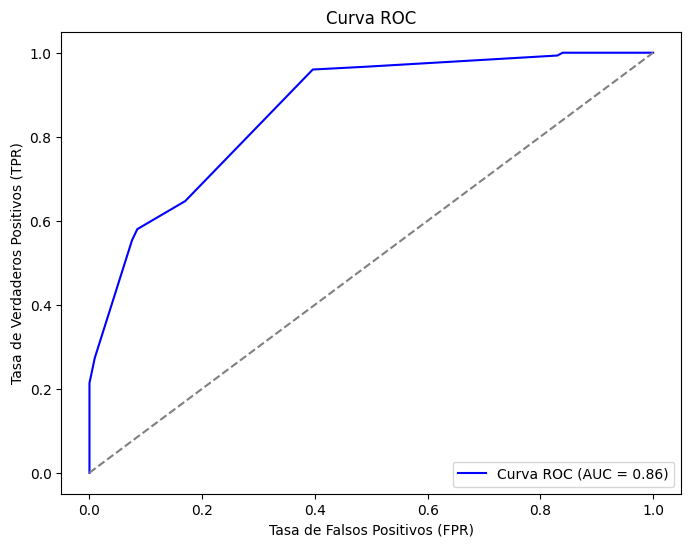

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la Curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

La curva ROC muestra cómo el modelo clasifica las instancias positivas y negativas según diferentes umbrales. El AUC de 0.86 indica que el modelo tiene una buena capacidad para diferenciar entre las clases, ya que la curva está lejos de la línea diagonal (que representa un modelo aleatorio). Esto significa que el modelo está acertando bien en distinguir entre las clases, con un buen balance entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR). A continuación, se revisarán los coeficientes del modelo de regresión logística para interpretar cómo cada variable afecta la predicción. Esto nos permitirá identificar qué características tienen mayor influencia en la clasificación, lo que es útil para comprender el comportamiento del modelo y, si es necesario, realizar ajustes que mejoren su desempeño. Este análisis también facilita la interpretabilidad del modelo, permitiendo ver de manera clara cómo las variables afectan las decisiones y predicciones que realiza.

In [77]:
# Obtener los coeficientes del modelo
coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": modelo.coef_[0]
})

# Ordenar los coeficientes por valor absoluto
coeficientes = coeficientes.sort_values(by="Coeficiente", ascending=False)

# Mostrar los coeficientes más importantes
print("\nCoeficientes del modelo:")
print(coeficientes)


Coeficientes del modelo:
               Variable  Coeficiente
0  home_goals_half_time     1.863667
1  away_goals_half_time    -1.742903


Al revisar los coeficientes del modelo, se observó que los goles del equipo local en el primer tiempo aumentan la probabilidad de que el equipo local gane, mientras que los goles del equipo visitante disminuyen esa probabilidad.

En resumen, el modelo es bastante bueno para predecir los resultados de los partidos, con las variables clave siendo los goles en el primer tiempo de ambos equipos. Aunque el rendimiento es sólido, siempre se pueden hacer ajustes para mejorar aún más la precisión del modelo.